# Using Decision Tree & Naive Bayes to classify Pokemon

## Import libraries

In [2]:
import gc
import random
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import pandas_profiling as pdp
import utils as ut
import decisionTree as dt
import naiveBayes as nb

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [ ]:
%reload_ext autoreload

In [3]:
# Set packages options
# np.set_printoptions(threshold=np.nan)
# pd.set_option("display.max_columns", 600)
plt.rcParams["figure.figsize"] = (9, 5)

## Define constants and functions

In [4]:
# Constants
TypeColorMappings = {"Water": "#6890F0", "Fire": "#F08030", "Grass": "#78C850",
                     "Dark": "#705848", "Electric": "#F8D030", "Flying": "#A890F0",
                     "Normal": "#A8A878", "Fighting": "#C03028", "Poison": "#A040A0",
                     "Ground": "#E0C068", "Psychic": "#F85888", "Rock": "#B8A038", 
                     "Ice": "#98D8D8", "Bug": "#A8B820", "Dragon": "#7038F8", 
                     "Ghost": "#705898", "Steel": "#B8B8D0", "Fairy": "#EE99AC"}

DropColumns = ["Pokedex", "Name", "Generation", "Category"]

def getColorList(typeCounts):
    assert type(typeCounts) == pd.core.series.Series, "Argument must be a Series object"
    return [TypeColorMappings[pokemonType] for pokemonType in typeCounts.index]

def getRandomColor():
    return "#%02X%02X%02X" % (random.randint(0,255), random.randint(0,255), random.randint(0,255))

def filterByValue(dataFrame, column, value):
    return dataFrame[dataFrame[column] == value]

## Load the data from file

In [5]:
# Load the Pokemon data
fileName = r'.\Pokemon_Cleaned.tsv'
columnTypes = {"Name": str, "Category": str, "Type 1": str, "Type 2": str, 
               "Ability 1": str, "Ability 2": str, "Ability 3": str, "Group": str}
data = pd.read_csv(fileName, header=0, sep='\t', dtype=columnTypes)
data.sample(5)

,Generation,Pokedex,Name,Category,Type 1,Type 2,Ability 1,Ability 2,Ability 3,MaleRatio,...,EggGroup 1,EggGroup 2,HP,Attack,Defense,Sp.Attack,Sp.Defense,Speed,Total,Group
285,2.0,245.0,Suicune,Aurora Pokemon,Water,None,Pressure,Inner Focus,None,0.0,...,Undiscovered,None,100.0,75.0,115.0,90.0,115.0,85.0,580,Legendary
858,7.0,738.0,Vikavolt,Stag Beetle Pokemon,Bug,Electric,Levitate,None,None,50.0,...,Bug,None,77.0,70.0,90.0,145.0,75.0,43.0,500,Ordinary
693,5.0,598.0,Ferrothorn,Thorn Pod Pokemon,Grass,Steel,Iron Barbs,Anticipation,None,50.0,...,Mineral,Grass,74.0,94.0,131.0,54.0,116.0,20.0,489,Ordinary
671,5.0,582.0,Vanillite,Fresh Snow Pokemon,Ice,None,Weak Armor,Ice Body,Snow Cloak,50.0,...,Mineral,None,36.0,50.0,50.0,65.0,60.0,44.0,305,Ordinary
874,7.0,748.0,Toxapex,Brutal Star Pokemon,Poison,Water,Merciless,Limber,Regenerator,50.0,...,Water 1,None,50.0,63.0,152.0,53.0,142.0,35.0,495,Ordinary


## Plot graphs to visualize and understand the data

### Group Distribution

In [ ]:
# Plot Group occurences to see the distributions
groupFig, groupAxes = plt.subplots(nrows=1, ncols=1)
groupCounts = data["Group"].value_counts()
groupAxe = groupCounts.plot(title="Group", kind="bar")
groupAxe.set(xlabel="Group Types", ylabel="Count")
plt.show()

### Plots of Pokemon vs. All Continuous Features & Generation vs. All Continuous Features

In [ ]:
ordi = filterByValue(data, "Group", "Ordinary")
lg = filterByValue(data, "Group", "Legendary")
ub = filterByValue(data, "Group", "Ultra Beast")

continuousFeatures = data.select_dtypes(include=[np.int64, np.float64]).drop(["Generation", "Pokedex"], axis=1)
combinations = []

for x in continuousFeatures:    
    for y in continuousFeatures:
        if not ((x, y) in combinations or (y, x) in combinations) and (x != y):
            combinations.append((x, y))

for x, y in combinations:
    axe = ordi.plot(x, y, kind="scatter", c="b")
    lg.plot(x, y, kind="scatter", c="r", ax=axe)
    ub.plot(x, y, kind="scatter", c="g", ax=axe)
    
#     figure, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,6.5))
    
#     axes[0].set_xlabel("Pokemon Index")
#     axes[0].set_ylabel(feature)
#     axes[0].scatter(ordi.index, ordi[feature], c="b", label="Ordinary")
#     axes[0].scatter(lg.index, lg[feature], c="r", label="Legendary")
#     axes[0].scatter(ub.index, ub[feature], c="g", label="Ultra Beast")
#     axes[0].legend(loc='best')
    
#     axes[1].set_xlabel("Generation")
#     axes[1].set_ylabel(feature)
#     axes[1].scatter(ordi["Generation"], ordi[feature], c="b", label="Ordinary")
#     axes[1].scatter(lg["Generation"], lg[feature], c="r", label="Legendary")
#     axes[1].scatter(ub["Generation"], ub[feature], c="g", label="Ultra Beast")
#     axes[1].legend(loc='best')

### Histograms of Continuous Features

In [ ]:
data.hist(figsize=(20,20))
plt.show()

We can see that features with uniform distribution may not contribute much to Decision Tree model because the model will be biased toward to those features since there is more entropy within those features.

### Box Plot of Total & Group

In [ ]:
data.boxplot("Total", "Group")
plt.title("Total & Group")
plt.suptitle("")
plt.show()

<p> According to the boxplot above, we can see that despite having a small quanity in size, <b>Legendary Pokemon</b> has the highest <b>Total</b> stats compared to the other 2 groups.</p>

## Training & Test Data

In [58]:
target = "Group"
labels = data[target].unique()
labelColors = {"Ordinary": "b", "Legendary": "r", "Ultra Beast": "g"}
probThresholds = pd.Series({"Ordinary": 0.4, "Ultra Beast": 0.3, "Legendary": 0.3})

# injectedData = ut.injectMinoritySample(["Ultra Beast", "Legendary"], "Group", data)
# reducedData = data.drop(DropColumns, axis=1)
# training, test = ut.splitData(target, reducedData, 0.65)

In [ ]:
print(training[target].value_counts())
print(test[target].value_counts())

## Decision Tree

In [99]:
dtree = dt.DecisionTree(target, maxDepth=3, probThresholds=probThresholds)
dtree.train(training)
dtPred = dtree.classify(test.drop([target], axis=1))

Function "train" took 15.41 seconds to complete


In [79]:
thresholds = []
for i in range(1, 10):
    threshold = i/10
    otherThreshold = (1 - threshold) / 2
    for j in range(len(labels)):
        tempDict = {}
        tempDict[labels[j]] = threshold
        for k in range(len(labels)):
            if (k != j):
                tempDict[labels[k]] = otherThreshold
        thresholds.append(pd.Series(tempDict))

In [ ]:
precisions = []
recalls = []
for t in thresholds:
    model = dt.DecisionTree(target, maxDepth=2, probThresholds=t)
    model.train(training, quiet=True)
    pred = model.classify(test.drop([target], axis=1))
    matrix = ut.buildConfusionMatrix(pred["Prediction"], test[target], labels)
    precision, recall = ut.getPrecisionsAndRecalls(matrix, labels)
    
    precisions.append(precision)
    recalls.append(recall)

In [125]:
ordiPR = []
lgPR = []
ubPR = []
for p, r in zip(precisions, recalls):
    ordiPR.append((r["Ordinary"], p["Ordinary"]))
    lgPR.append((r["Legendary"], p["Legendary"]))
    ubPR.append((r["Ultra Beast"], p["Ultra Beast"]))

ordiPR.sort(key=lambda x: x[0])
lgPR.sort(key=lambda x: x[0])
ubPR.sort(key=lambda x: x[0])

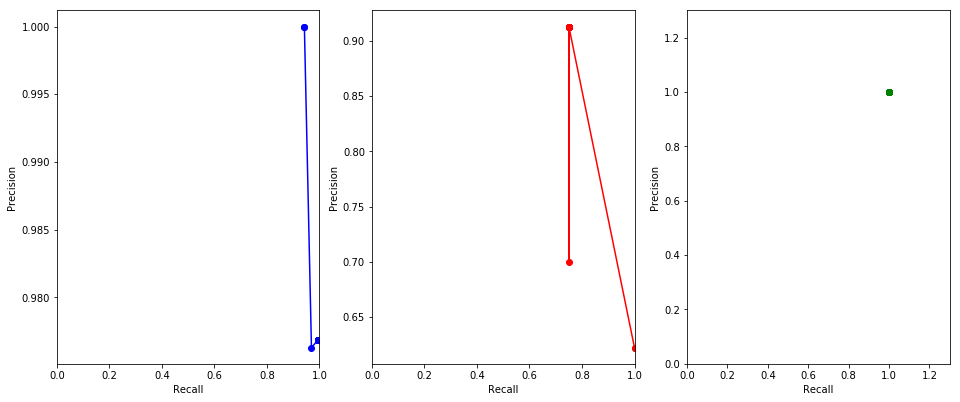

In [148]:
figure, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,6.5))
    
axes[0].set_xlabel("Recall")
axes[0].set_ylabel("Precision")
axes[0].set_xlim([0, 1])
axes[0].plot([i[0] for i in ordiPR], [i[1] for i in ordiPR], 'bo-')

axes[1].set_xlabel("Recall")
axes[1].set_ylabel("Precision")
axes[1].set_xlim([0, 1])
axes[1].plot([i[0] for i in lgPR], [i[1] for i in lgPR], 'ro-')

axes[2].set_xlabel("Recall")
axes[2].set_ylabel("Precision")
axes[2].set_xlim([0, 1.3])
axes[2].set_ylim([0, 1.3])
axes[2].plot([i[0] for i in ubPR], [i[1] for i in ubPR], 'go-')

In [130]:
ubPR

[(1.0, 1.0),
 (1.0, 1.0),
 (1.0, 1.0),
 (1.0, 1.0),
 (1.0, 1.0),
 (1.0, 1.0),
 (1.0, 1.0),
 (1.0, 1.0),
 (1.0, 1.0),
 (1.0, 1.0),
 (1.0, 1.0),
 (1.0, 1.0),
 (1.0, 1.0),
 (1.0, 1.0),
 (1.0, 1.0),
 (1.0, 1.0),
 (1.0, 1.0),
 (1.0, 1.0),
 (1.0, 1.0),
 (1.0, 1.0),
 (1.0, 1.0),
 (1.0, 1.0),
 (1.0, 1.0),
 (1.0, 1.0),
 (1.0, 1.0),
 (1.0, 1.0),
 (1.0, 1.0)]

In [83]:
recalls

[{'Legendary': 0.75, 'Ordinary': 0.9932659932659933, 'Ultra Beast': 1.0}]

In [ ]:
thresholds

In [8]:
# Use Decision Tree to train on the training set and predict on the test set
dtree = dt.DecisionTree(target, maxDepth=4)
dtree.train(training)
dtPred = dtree.classify(test.drop([target], axis=1))

Function "train" took 28.46 seconds to complete


In [53]:
dtMatrix = ut.buildConfusionMatrix(dtPred["Prediction"], test[target], labels)
dtPrecisions, dtRecalls = ut.getPrecisionsAndRecalls(dtMatrix, labels)
dtFScores = ut.computeFScores(dtPrecisions, dtRecalls)
"Error {0:.2f}%".format(ut.computeError(dtPred["Prediction"], test["Group"]) * 100)

'Error 2.74%'

### Decision Tree Confusion Matrix

In [ ]:
dtMatrix

In [ ]:
dtPrecisions

In [ ]:
dtRecalls

In [ ]:
dtFScores

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import label_binarize

In [ ]:

yhat = [v[0] for v in dtPred.values]
yhatProb = [v[1] for v in dtPred.values]
ytrue = test[target]
# ytrue = []
# for v in test[target]:
#     if (v == "Ordinary"):
#         ytrue.append(0)
#     elif (v == "Legendary"):
#         ytrue.append(1)
#     else:
#         ytrue.append(2)
        
        
precision = dict()
recall = dict()
avgPrec = dict()

for label in labels:
    precision[label], recall[label], _ = precision_recall_curve(ytrue, yhatProb, pos_label=label)
    #avgPrec[label] = average_precision_score(ytrue, yhatProb)



In [ ]:
for i in labels:
    l, = plt.plot(recall[i], precision[i], lw=2)

### Decision Tree Depth

In [ ]:
treeDepths = [i for i in range(10)]
depthErrors = []
for depth in treeDepths:
    learner = dt.DecisionTree(target, depth)
    learner.train(training, quiet=True)
    pred = learner.classify(test.drop([target], axis=1))
    err = ut.computeError(pred, test["Group"])
    depthErrors.append(err)

In [ ]:
plt.plot(treeDepths, depthErrors, 'bo-')
plt.title("Decision Tree Depth")
plt.xlabel("Tree Depth")
plt.ylabel("Error Rate")
plt.show()

### Decision Tree ROC Curve

In [ ]:
# For each label, treat other labels as "negative"
for label in labels:
    c = labelColors[label]
    fpr, tpr, thresholds = roc_curve(y_true=test[target], y_score=[v[1] for v in dtPred.values], pos_label=label)
    rocAuc = auc(fpr, tpr)
    plt.plot(fpr, tpr, c, label='{0} AUC = {1:.2f}'.format(label, rocAuc))
    
plt.title('Receiver Operating Characteristic')
plt.legend(loc='best')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0, 1.05])
plt.ylim([0, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Decision Tree K Fold Cross Validation from k=2 to k=10

In [ ]:
dtKErrors = ut.kFoldCrossValidationResult(10, target, training, dtree)

### Compute the and means, variances, and standard deviations of the k fold cross validation result

In [ ]:
means = [sum(e) / len(e) for e in dtKErrors]
stds =  []
variances = []

for e, m in zip(dtKErrors, means):
    v = sum(map(lambda x: (x - m)**2, e)) / len(e)
    s = math.sqrt(v)
    variances.append(v)
    stds.append(s)

### Plot the error rates represented by the mean, variance, and standard deviation

In [ ]:
figure, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 8))
figure.subplots_adjust(top=1.5, bottom=0.5)

kRange = range(2, 2 + len(means))

axes[0, 0].plot([i for i in kRange], means, "bo-", label="Mean")
axes[0, 0].plot([i for i in kRange], variances, "ro-", label="Variance")
axes[0, 0].plot([i for i in kRange], stds, "go-", label="Standard Deviation")
axes[0, 0].set_title("Decision Tree K Fold Error Summary")
axes[0, 0].set_xlabel("k Folds")
axes[0, 0].set_ylabel("Error Rate")
axes[0, 0].legend(loc="best")

axes[0, 1].plot([i for i in kRange], means, "bo-", label="Mean")
axes[0, 1].set_title("Decision Tree K Fold Mean Error")
axes[0, 1].set_xlabel("k Folds")
axes[0, 1].set_ylabel("Error Rate")
axes[0, 1].legend(loc="best")

axes[1, 1].plot([i for i in kRange], variances, "ro-", label="Variance")
axes[1, 1].set_title("Decision Tree K Fold Variance Error")
axes[1, 1].set_xlabel("k Folds")
axes[1, 1].set_ylabel("Error Rate")
axes[1, 1].legend(loc="best")

axes[1, 0].plot([i for i in kRange], stds, "go-", label="Standard Deviation")
axes[1, 0].set_title("Decision Tree K Fold Standard Deviation Error")
axes[1, 0].set_xlabel("k Folds")
axes[1, 0].set_ylabel("Error Rate")
axes[1, 0].legend(loc="best")
plt.show()

## Naive Bayes

In [ ]:
# Use Naive Bayes to train on the training set and predict on the test data set
nBayes = nb.NaiveBayes(target, labels)
nBayes.train(training)
nbPred = nBayes.classify(test.drop([target], axis=1))

In [ ]:
nbMatrix = ut.buildConfusionMatrix(nbPred["Prediction"], test[target], reducedData[target].unique())
nbPrecisions, nbRecalls = ut.getPrecisionsAndRecalls(nbMatrix, reducedData[target].unique())
nbFScores = ut.computeFScores(nbPrecisions, nbRecalls)
nbSens, nbSpec = ut.getSensitivityAndSpecifiicy(nbMatrix, reducedData[target].unique())
"Error: {0:.2f}%".format(ut.computeError(nbPred["Prediction"], test["Group"]) * 100)

### Naive Bayes Confustion Matrix

In [ ]:
nbMatrix

### Naive Bayes ROC Curve

In [ ]:
# For each label, treat other labels as "negative"
for label in labels:
    c = labelColors[label]
    fpr, tpr, thresholds = roc_curve(y_true=test[target], y_score=[v[1] for v in nbPred.values], pos_label=label)
    rocAuc = auc(fpr, tpr)
    plt.plot(fpr, tpr, c, label='{0} AUC = {1:.2f}'.format(label, rocAuc))
    
plt.title('Receiver Operating Characteristic')
plt.legend(loc='best')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Perform K Fold Cross Validations from k=2 to k=10

In [ ]:
nbKErrors = ut.kFoldCrossValidationResult(10, target, training, nBayes)

### Compute the and means, variances, and standard deviations of the k fold cross validation result

In [ ]:
means = [sum(e) / len(e) for e in nbKErrors]
stds =  []
variances = []

for e, m in zip(nbKErrors, means):
    v = sum(map(lambda x: (x - m)**2, e)) / len(e)
    s = math.sqrt(v)
    variances.append(v)
    stds.append(s)

### Plot the error rates represented by the mean, variance, and standard deviation

In [ ]:
figure, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 8))
figure.subplots_adjust(top=1.5, bottom=0.5)

kRange = range(2, 2 + len(means))

axes[0, 0].plot([i for i in kRange], means, "bo-", label="Mean")
axes[0, 0].plot([i for i in kRange], variances, "ro-", label="Variance")
axes[0, 0].plot([i for i in kRange], stds, "go-", label="Standard Deviation")
axes[0, 0].set_title("Naive Bayes K Fold Error Summary")
axes[0, 0].set_xlabel("k Folds")
axes[0, 0].set_ylabel("Error Rate")
axes[0, 0].legend(loc="best")

axes[0, 1].plot([i for i in kRange], means, "bo-", label="Mean")
axes[0, 1].set_title("Naive Bayes K Fold Mean Error")
axes[0, 1].set_xlabel("k Folds")
axes[0, 1].set_ylabel("Error Rate")
axes[0, 1].legend(loc="best")

axes[1, 1].plot([i for i in kRange], variances, "ro-", label="Variance")
axes[1, 1].set_title("Naive Bayes K Fold Variance Error")
axes[1, 1].set_xlabel("k Folds")
axes[1, 1].set_ylabel("Error Rate")
axes[1, 1].legend(loc="best")

axes[1, 0].plot([i for i in kRange], stds, "go-", label="Standard Deviation")
axes[1, 0].set_title("Naive Bayes K Fold Standard Deviation Error")
axes[1, 0].set_xlabel("k Folds")
axes[1, 0].set_ylabel("Error Rate")
axes[1, 0].legend(loc="best")
plt.show()

### Playground

In [ ]:
r = ut.injectMinoritySample(["Ultra Beast", "Legendary"], "Group", data)

In [ ]:
r[target].value_counts()

In [ ]:
# Get data profile
profile = pdp.ProfileReport(dataWithDummies)
profile.to_file("Profile.html")
profile = None
gc.collect()